In [356]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import math
import seaborn as sns
from scipy.stats import randint

In [357]:
teamname = "Santos"

matches = pd.read_csv("spi_matches.csv")
if(teamname == "all") :
    team_matches = matches
else :
    team_matches = matches[np.logical_or(matches['team1'] == teamname, matches['team2'] == teamname)]
team_matches_data = team_matches.loc[:, ['date', 'team1', 'team2', 'score1', 'score2', 'prob1', 'prob2', 'importance1', 'importance2', 'spi1', 'spi2']]

# Cleaning dataset and creating columns for team data 

In [358]:
for label, row in team_matches_data.iterrows() :
    print(str(row["date"]) + " : " + str(row["team1"]) + " " + str(row["score1"])[0] + "x"  + str(row["score2"])[0] + " " + str(row["team2"]))
    if(row['team1'] == teamname) :
        team_matches_data.loc[label, "goals_team"] = row['score1']
        team_matches_data.loc[label, "goals_adv"] = row['score2']
        team_matches_data.loc[label, "adv_team"] = row['team2']
        team_matches_data.loc[label, "place"] = "home"
        team_matches_data.loc[label, "prob_team"] = row['prob1']
        team_matches_data.loc[label, "spi_team"] = row['spi1']
        team_matches_data.loc[label, "spi_adv"] = row['spi2']
        team_matches_data.loc[label, "spi_dif"] = row['spi1'] - row['spi2']
        if(math.isnan(row['importance1'])) :
            team_matches_data.loc[label, "importance_team"] = 25.0
        else : 
            team_matches_data.loc[label, "importance_team"] = row['importance1']
        
        if(math.isnan(row['score1'])) :
            team_matches_data.loc[label, "goals_team"] = 0.0
            team_matches_data.loc[label, "goals_team_str"] = 0
        elif row['score1'] >= 3:
            team_matches_data.loc[label, "goals_team_str"] = 3
        else :
            team_matches_data.loc[label, "goals_team_str"] = int(row['score1'])
            
        if(math.isnan(row['score2'])) :
            team_matches_data.loc[label, "goals_away"] = 0.0
            team_matches_data.loc[label, "goals_away_str"] = 0
        elif row['score2'] >= 3:
            team_matches_data.loc[label, "goals_away_str"] = 3
        else :
            team_matches_data.loc[label, "goals_away_str"] = int(row['score2'])
            
    else :
        team_matches_data.loc[label, "goals_team"] = row['score2']
        team_matches_data.loc[label, "goals_adv"] = row['score1']
        team_matches_data.loc[label, "adv_team"] = row['team1']
        team_matches_data.loc[label, "place"] = "away"
        team_matches_data.loc[label, "prob_team"] = row['prob2']
        team_matches_data.loc[label, "spi_team"] = row['spi2']
        team_matches_data.loc[label, "spi_adv"] = row['spi1']
        team_matches_data.loc[label, "spi_dif"] = row['spi2'] - row['spi1']
        if(math.isnan(row['importance2'])) :
            team_matches_data.loc[label, "importance_team"] = 25.0
        else :
            team_matches_data.loc[label, "importance_team"] = row['importance2']
            
        if(math.isnan(row['score1'])) :
            team_matches_data.loc[label, "goals_away"] = 0.0
            team_matches_data.loc[label, "goals_away_str"] = 0
        elif row['score1'] >= 3:
            team_matches_data.loc[label, "goals_away_str"] = 3
        else :
            team_matches_data.loc[label, "goals_away_str"] = int(row['score1'])
            
        if(math.isnan(row['score1'])) :
            team_matches_data.loc[label, "goals_team"] = 0.0
            team_matches_data.loc[label, "goals_team_str"] = 0
        elif row['score2'] >= 3:
            team_matches_data.loc[label, "goals_team_str"] = 3
        else :
            team_matches_data.loc[label, "goals_team_str"] = int(row['score2'])

2017-05-14 : Fluminense 3x2 Santos
2017-05-20 : Santos 1x0 Coritiba
2017-05-28 : Santos 0x1 Cruzeiro
2017-06-03 : Corinthians 2x0 Santos
2017-06-07 : Santos 1x0 Botafogo
2017-06-11 : Atlético Paranaense 0x2 Santos
2017-06-14 : Santos 1x0 Palmeiras
2017-06-17 : Santos 0x0 Ponte Preta
2017-06-21 : Vítoria 0x2 Santos
2017-06-24 : Santos 0x1 Sport Recife
2017-07-01 : Atlético Goianiense 1x1 Santos
2017-07-09 : Santos 3x2 São Paulo
2017-07-12 : Atletico Mineiro 0x1 Santos
2017-07-16 : Vasco da Gama 0x0 Santos
2017-07-19 : Santos 1x0 Chapecoense AF
2017-07-23 : Santos 3x0 Bahía
2017-07-30 : Grêmio 1x1 Santos
2017-08-02 : Santos 3x2 Flamengo
2017-08-06 : Avaí 0x0 Santos
2017-08-14 : Santos 0x0 Fluminense
2017-08-20 : Coritiba 0x0 Santos
2017-08-27 : Cruzeiro 1x1 Santos
2017-09-10 : Santos 2x0 Corinthians
2017-09-16 : Botafogo 2x0 Santos
2017-09-23 : Santos 1x0 Atlético Paranaense
2017-09-30 : Palmeiras 0x1 Santos
2017-10-12 : Ponte Preta 1x1 Santos
2017-10-16 : Santos 2x2 Vítoria
2017-10-19 :

# Creating data visualizations

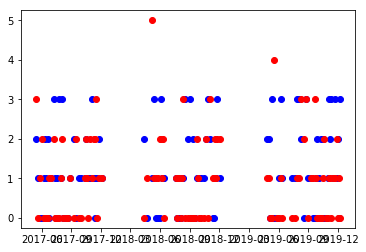

<Figure size 432x288 with 0 Axes>

In [359]:
team_matches_data.loc[:, "datetimeobj"] = team_matches_data.loc[:, "date"].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d"))

plt.plot_date(x=team_matches_data.loc[:, 'datetimeobj'], y=team_matches_data.loc[:,'goals_team_str'], xdate = True, ydate = False, color = 'blue')
plt.plot_date(x=team_matches_data.loc[:, 'datetimeobj'], y=team_matches_data.loc[:,'goals_adv'], xdate = True, ydate = False, color = 'red')
plt.show()
plt.clf()

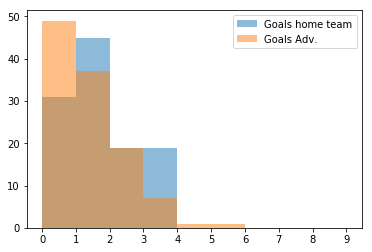

<Figure size 432x288 with 0 Axes>

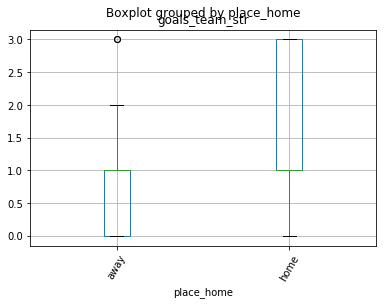

<Figure size 432x288 with 0 Axes>

In [360]:
plt.hist(team_matches_data['goals_team_str'], bins = range(10), alpha=0.5, label='Goals home team')
plt.hist(team_matches_data['goals_adv'], bins = range(10), alpha=0.5, label='Goals Adv.')
plt.legend(loc='upper right')
plt.xticks(range(10))
plt.show()
plt.clf()

team_done_matches = team_matches_data[team_matches_data['datetimeobj'] < datetime.datetime.now() - datetime.timedelta(days=1)]
team_predict = team_done_matches[['goals_team_str','prob_team', 'importance_team', 'spi_dif', 'place']]
team_predict = pd.get_dummies(team_predict, drop_first = True)



team_predict.boxplot('goals_team_str', 'place_home', rot=60)
plt.xticks([1, 2], ['away', 'home'])
plt.show()
plt.clf()

# Training kNeighbors to predict goal numbers

{'n_neighbors': 33}
0.40350877192982454
Predicted scores = 
[1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


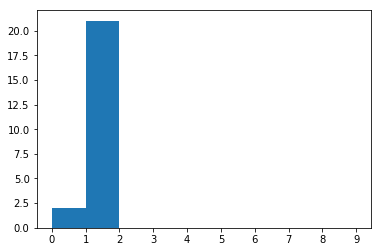


Precision of model = 
0.391304347826087

Confusion Matrix: 
[[0 0 2 0]
 [7 9 1 4]
 [0 0 0 0]
 [0 0 0 0]]

Classification: 
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         2
        1.0       1.00      0.43      0.60        21
        2.0       0.00      0.00      0.00         0
        3.0       0.00      0.00      0.00         0

avg / total       0.91      0.39      0.55        23

Model predicted 1 goal(s) against Fluminense -- Real result = 0 [0=0.364, 1=0.424, 2=0.152, 3+=0.061]

Result predicted correctly! 1 goal(s) against Coritiba -- [0=0.212, 1=0.394, 2=0.182, 3+=0.212]

Result predicted correctly! 1 goal(s) against Cruzeiro -- [0=0.394, 1=0.424, 2=0.152, 3+=0.03]

Model predicted 0 goal(s) against Corinthians -- Real result = 2 [0=0.394, 1=0.364, 2=0.152, 3+=0.091]

Result predicted correctly! 1 goal(s) against Botafogo -- [0=0.333, 1=0.485, 2=0.121, 3+=0.061]

Model predicted 1 goal(s) against Atlético Paranaense -- R

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


<Figure size 432x288 with 0 Axes>

In [361]:
X = team_predict.drop('goals_team_str', axis=1).values
y = team_predict['goals_team_str'].values

X = scale(X)

#Discovering best parameter for k_neighbors
param_grid={'n_neighbors': np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv = 5)

knn_cv.fit(X, y)

print(knn_cv.best_params_)
print(knn_cv.best_score_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=knn_cv.best_params_['n_neighbors'])
knn.fit(X_train,y_train)
print("Predicted scores = ") 
print(knn.predict(X_test))
plt.hist(knn.predict(X_test), bins = range(10), alpha=1, label='Number of goals')
plt.xticks(range(10))
plt.show()
plt.clf()
print("\nPrecision of model = ") 
print(knn.score(X_test, y_test))
print("\nConfusion Matrix: ")
print(confusion_matrix(knn.predict(X_test), y_test))
print("\nClassification: ")
print(classification_report(knn.predict(X_test), y_test))

KNN_score = knn.score(X_test, y_test)

y_pred = knn.predict(X_test)
# Compute predicted probabilities: y_pred_prob
y_pred_prob = knn.predict_proba(X_test)

adv_teams = team_done_matches['adv_team'].values

for i in range(y_pred_prob.shape[0]) :
    if y_pred[i] != y_test[i]:
        print("Model predicted " + (str(int(y_pred[i])) if y_pred[i]<3 else "3+")  + " goal(s) against " + adv_teams[i] + " -- Real result = " + (str(int(y_test[i])) if y_test[i]<3 else "3+") + " [0=" + str(round(y_pred_prob[i][0], 3)) + ", 1=" + str(round(y_pred_prob[i][1], 3)) + ", 2=" + str(round(y_pred_prob[i][2], 3)) + ", 3+=" + str(round(y_pred_prob[i][3], 3)) + "]" + "\n") 
    else :
        print("Result predicted correctly! " + (str(int(y_pred[i])) if y_pred[i]<3 else "3+") + " goal(s) against " + adv_teams[i] + " -- "+ "[0=" + str(round(y_pred_prob[i][0], 3)) + ", 1=" + str(round(y_pred_prob[i][1], 3)) + ", 2=" + str(round(y_pred_prob[i][2], 3)) + ", 3+=" + str(round(y_pred_prob[i][3], 3)) + "]" + "\n") 

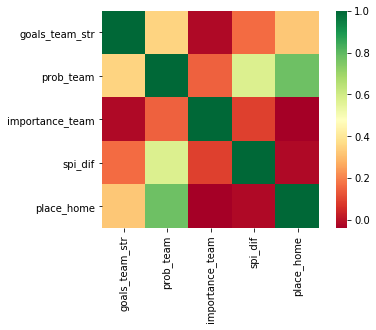

In [362]:
ax = sns.heatmap(team_predict.corr(), square=True, cmap='RdYlGn')
plt.show()

# Trying linear regression to predict goals

With one variable (prob_team first and spi_dif after)

0.12419313108362762


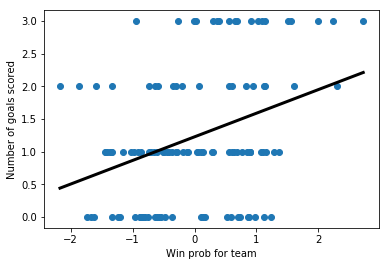

R^2: 0.07366092662796708
Root Mean Squared Error: 1.0095286484618757
[-0.16358113  0.20525939 -0.04687696  0.19046762  0.21258427]


<Figure size 432x288 with 0 Axes>

In [363]:
reg = LinearRegression()

X = team_predict['prob_team'].values.reshape(-1,1)
y = team_predict['goals_team_str'].values.reshape(-1,1)

X = scale(X)

prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
reg.fit(X, y)
result = reg.predict(prediction_space)
print(reg.score(X,y))

LinRegProb_score = reg.score(X,y)

# Plot regression line
plt.scatter(X,y)
plt.plot(prediction_space, result, color='black', linewidth=3)
plt.xlabel("Win prob for team")
plt.ylabel("Number of goals scored")
plt.show()
plt.clf()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("R^2: {}".format(reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

cv_scores = cross_val_score(reg, X, y, cv=5)
print(cv_scores)

0.026978962975829024


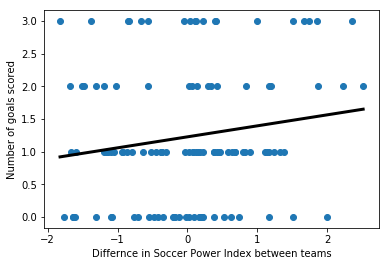

R^2: -0.05986961098735466
Root Mean Squared Error: 1.0798411575364766
[-0.1624182   0.00165525  0.04512961  0.01157197  0.06525954]


<Figure size 432x288 with 0 Axes>

In [364]:
reg2 = LinearRegression()

X = team_predict['spi_dif'].values.reshape(-1,1)
y = team_predict['goals_team_str'].values.reshape(-1,1)

X = scale(X)

prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
reg2.fit(X, y)
result = reg2.predict(prediction_space)
print(reg2.score(X,y))

LinRegDif_score = reg2.score(X,y)

# Plot regression line
plt.scatter(X,y)
plt.plot(prediction_space, result, color='black', linewidth=3)
plt.xlabel("Differnce in Soccer Power Index between teams")
plt.ylabel("Number of goals scored")
plt.show()
plt.clf()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
reg2.fit(X_train, y_train)
y_pred = reg2.predict(X_test)
print("R^2: {}".format(reg2.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

cv_scores = cross_val_score(reg, X, y, cv=5)
print(cv_scores)

Trying with all variables


Predictions

[0.32675662 1.51975133 0.62168356 0.56620767 1.08368598 1.33154945
 1.79560948 1.6582501  1.23014438 1.36983058 1.04834608 0.63717668
 1.57439486 0.88924679 1.24907299 0.91923355 1.2917965  0.98398282
 1.43979676 0.82652665 1.01146358 1.81579284 0.69797403]

Score

0.031644169682671475

Coeficients

[ 0.0448163  -0.07522524  0.21496231  0.28689699]
1.2183181867785104


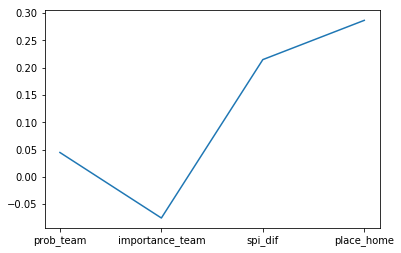

<Figure size 432x288 with 0 Axes>

In [365]:
reg_all = LinearRegression()

X = team_predict.drop('goals_team_str', axis=1).values
y = team_predict['goals_team_str'].values

X = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
reg_all.fit(X_train, y_train)
y_pred = reg_all.predict(X_test)

print("\nPredictions\n")
print(y_pred)
print("\nScore\n")
print(reg_all.score(X_test, y_test))
print("\nCoeficients\n")
print(reg_all.coef_)
print(reg_all.intercept_)

plt.plot(team_predict.drop('goals_team_str', axis = 1).columns, reg_all.coef_)
plt.show()
plt.clf()

LinReg_score = reg_all.score(X_test, y_test)

# Logistic regression

In [366]:
X = team_predict.drop('goals_team_str', axis=1).values
y = team_predict['goals_team_str'].values

X = scale(X)

#Choosing best parameter for model
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}
reg_log = LogisticRegression()
reg_log_cv = GridSearchCV(reg_log, param_grid, cv=5)
reg_log_cv.fit(X, y)

print("Melhor score com parametro = " + str(reg_log_cv.best_score_))
print(reg_log_cv.best_params_)

reg_log = LogisticRegression(C = reg_log_cv.best_params_['C'], penalty = reg_log_cv.best_params_['penalty'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
reg_log.fit(X_train, y_train)
y_pred = reg_log.predict(X_test)

print("\nPredictions\n")
print(y_pred)
print("\nPrecision of model = ") 
print(reg_log.score(X_test, y_test))
print("\nConfusion Matrix: ")
print(confusion_matrix(reg_log.predict(X_test), y_test))
print("\nClassification: ")
print(classification_report(reg_log.predict(X_test), y_test))

LogReg_score = reg_log.score(X_test, y_test)

y_pred = reg_log.predict(X_test)
# Compute predicted probabilities: y_pred_prob
y_pred_prob = reg_log.predict_proba(X_test)

adv_teams = team_done_matches['adv_team'].values

for i in range(y_pred_prob.shape[0]) :
    if y_pred[i] != y_test[i]:
        print("Model predicted " + (str(int(y_pred[i])) if y_pred[i]<3 else "3+")  + " goal(s) against " + adv_teams[i] + " -- Real result = " + (str(int(y_test[i])) if y_test[i]<3 else "3+") + " [0=" + str(round(y_pred_prob[i][0], 3)) + ", 1=" + str(round(y_pred_prob[i][1], 3)) + ", 2=" + str(round(y_pred_prob[i][2], 3)) + ", 3+=" + str(round(y_pred_prob[i][3], 3)) + "]" + "\n") 
    else :
        print("Result predicted correctly! " + (str(int(y_pred[i])) if y_pred[i]<3 else "3+") + " goal(s) against " + adv_teams[i] + " -- "+ "[0=" + str(round(y_pred_prob[i][0], 3)) + ", 1=" + str(round(y_pred_prob[i][1], 3)) + ", 2=" + str(round(y_pred_prob[i][2], 3)) + ", 3+=" + str(round(y_pred_prob[i][3], 3)) + "]" + "\n") 

Melhor score com parametro = 0.39473684210526316
{'C': 0.05179474679231213, 'penalty': 'l1'}

Predictions

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Precision of model = 
0.391304347826087

Confusion Matrix: 
[[0 0 0 0]
 [7 9 3 4]
 [0 0 0 0]
 [0 0 0 0]]

Classification: 
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         0
        1.0       1.00      0.39      0.56        23
        2.0       0.00      0.00      0.00         0
        3.0       0.00      0.00      0.00         0

avg / total       1.00      0.39      0.56        23

Model predicted 1 goal(s) against Fluminense -- Real result = 0 [0=0.273, 1=0.287, 2=0.223, 3+=0.217]

Result predicted correctly! 1 goal(s) against Coritiba -- [0=0.273, 1=0.287, 2=0.223, 3+=0.217]

Result predicted correctly! 1 goal(s) against Cruzeiro -- [0=0.273, 1=0.287, 2=0.223, 3+=0.217]

Model predicted 1 goal(s) against Corinthians -- Real result = 2 [0=0.273, 1=0.2

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Decision tree model

In [367]:
X = team_predict.drop('goals_team_str', axis=1).values
y = team_predict['goals_team_str'].values

X = scale(X)

#Finding best parameters for Decision tree
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 5),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()
# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)
# Fit it to the data
tree_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

tree = DecisionTreeClassifier(criterion = tree_cv.best_params_['criterion'], max_depth = tree_cv.best_params_['max_depth'], max_features = tree_cv.best_params_['max_features'], min_samples_leaf = tree_cv.best_params_['min_samples_leaf'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print("\nPredictions\n")
print(y_pred)
print("\nPrecision of model = ") 
print(tree.score(X_test, y_test))
print("\nConfusion Matrix: ")
print(confusion_matrix(tree.predict(X_test), y_test))
print("\nClassification: ")
print(classification_report(tree.predict(X_test), y_test))

Tree_score = tree.score(X_test, y_test)

# Compute predicted probabilities: y_pred_prob
y_pred_prob = tree.predict_proba(X_test)

adv_teams = team_done_matches['adv_team'].values

for i in range(y_pred_prob.shape[0]) :
    if y_pred[i] != y_test[i]:
        print("Model predicted " + (str(int(y_pred[i])) if y_pred[i]<3 else "3+")  + " goal(s) against " + adv_teams[i] + " -- Real result = " + (str(int(y_test[i])) if y_test[i]<3 else "3+") + " [0=" + str(round(y_pred_prob[i][0], 3)) + ", 1=" + str(round(y_pred_prob[i][1], 3)) + ", 2=" + str(round(y_pred_prob[i][2], 3)) + ", 3+=" + str(round(y_pred_prob[i][3], 3)) + "]" + "\n") 
    else :
        print("Result predicted correctly! " + (str(int(y_pred[i])) if y_pred[i]<3 else "3+") + " goal(s) against " + adv_teams[i] + " -- "+ "[0=" + str(round(y_pred_prob[i][0], 3)) + ", 1=" + str(round(y_pred_prob[i][1], 3)) + ", 2=" + str(round(y_pred_prob[i][2], 3)) + ", 3+=" + str(round(y_pred_prob[i][3], 3)) + "]" + "\n") 

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 1}
Best score is 0.40350877192982454

Predictions

[0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 3. 0. 1. 0. 1. 0. 0. 3. 0.]

Precision of model = 
0.43478260869565216

Confusion Matrix: 
[[4 4 3 0]
 [2 5 0 3]
 [0 0 0 0]
 [1 0 0 1]]

Classification: 
             precision    recall  f1-score   support

        0.0       0.57      0.36      0.44        11
        1.0       0.56      0.50      0.53        10
        2.0       0.00      0.00      0.00         0
        3.0       0.25      0.50      0.33         2

avg / total       0.54      0.43      0.47        23

Result predicted correctly! 0 goal(s) against Fluminense -- [0=0.8, 1=0.0, 2=0.2, 3+=0.0]

Result predicted correctly! 1 goal(s) against Coritiba -- [0=0.286, 1=0.321, 2=0.214, 3+=0.179]

Model predicted 0 goal(s) against Cruzeiro -- Real result = 1 [0=0.423, 1=0.423, 2=0.115, 3+=0.038]

Model predicted 0 goal(s) agai

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Ridge model

In [368]:
X = team_predict.drop('goals_team_str', axis=1).values
y = team_predict['goals_team_str'].values

X = scale(X)

# Setup the parameters and distributions to sample from: param_dist
linear_space = np.linspace(0, 1)

param_dist = {"alpha": linear_space}

ridge_reg = Ridge()

ridge_reg_cv = GridSearchCV(ridge_reg, param_dist, cv=5)

ridge_reg_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(ridge_reg_cv.best_params_))
print("Best score is {}".format(ridge_reg_cv.best_score_))

ridge_reg = Ridge(alpha = ridge_reg_cv.best_params_['alpha'], normalize = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
ridge_reg.fit(X_train, y_train)
y_pred = ridge_reg.predict(X_test)

print("\nPredictions\n")
print(y_pred)
print("\nPrecision of model = ") 
print(ridge_reg.score(X_test, y_test))

print("\nR^2: {}".format(ridge_reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

Ridge_score = ridge_reg.score(X_test, y_test)

Tuned Decision Tree Parameters: {'alpha': 1.0}
Best score is 0.002606017031404352

Predictions

[0.66226024 1.42565294 0.84420682 0.76006255 1.13692448 1.31788156
 1.56011208 1.50650332 1.23578667 1.32892049 1.11144206 0.85154668
 1.48167164 1.03737433 1.24164904 1.03726667 1.22671327 1.05265795
 1.39061116 0.97365562 1.07319725 1.64238921 0.89987435]

Precision of model = 
0.06377380667195609

R^2: 0.06377380667195609
Root Mean Squared Error: 1.0149018637472587


# Lasso model

In [374]:
X = team_predict.drop('goals_team_str', axis=1).values
y = team_predict['goals_team_str'].values

X = scale(X)

# Setup the parameters and distributions to sample from: param_dist
linear_space = np.linspace(0, 1)

param_dist = {"alpha": linear_space}

lasso_reg = Lasso()

lasso_reg_cv = GridSearchCV(lasso_reg, param_dist, cv=5)

lasso_reg_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(lasso_reg_cv.best_params_))
print("Best score is {}".format(lasso_reg_cv.best_score_))

lasso_reg = Lasso(normalize = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
lasso_reg.fit(X_train, y_train)
y_pred = lasso_reg.predict(X_test)

print("\nPredictions\n")
print(y_pred)
print("\nPrecision of model = ") 
print(lasso_reg.score(X_test, y_test))

print("\nR^2: {}".format(lasso_reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

Lasso_score = lasso_reg.score(X_test, y_test)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_pa

Tuned Decision Tree Parameters: {'alpha': 0.1020408163265306}
Best score is 0.04460650180747582

Predictions

[1.24175824 1.24175824 1.24175824 1.24175824 1.24175824 1.24175824
 1.24175824 1.24175824 1.24175824 1.24175824 1.24175824 1.24175824
 1.24175824 1.24175824 1.24175824 1.24175824 1.24175824 1.24175824
 1.24175824 1.24175824 1.24175824 1.24175824 1.24175824]

Precision of model = 
-0.004183800037430352

R^2: -0.004183800037430352
Root Mean Squared Error: 1.051090865171263


# Suport vector machine model

In [370]:
X = team_predict.drop('goals_team_str', axis=1).values
y = team_predict['goals_team_str'].values

X = scale(X)

#Choosing best parameter for model
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
reg_svc = SVC()
reg_svc_cv = GridSearchCV(reg_svc, param_grid, cv=5)
reg_svc_cv.fit(X, y)

print("Melhor score com parametro = " + str(reg_svc_cv.best_score_))
print(reg_svc_cv.best_params_)

svc_log = LogisticRegression(C = reg_svc_cv.best_params_['C'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
reg_svc.fit(X_train, y_train)
y_pred = reg_svc.predict(X_test)

print("\nPredictions\n")
print(y_pred)
print("\nPrecision of model = ") 
print(reg_svc.score(X_test, y_test))
print("\nConfusion Matrix: ")
print(confusion_matrix(reg_svc.predict(X_test), y_test))
print("\nClassification: ")
print(classification_report(reg_svc.predict(X_test), y_test))

SVM_score = reg_svc.score(X_test, y_test)

Melhor score com parametro = 0.39473684210526316
{'C': 1e-05}

Predictions

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1.]

Precision of model = 
0.4782608695652174

Confusion Matrix: 
[[1 0 0 0]
 [6 9 3 3]
 [0 0 0 0]
 [0 0 0 1]]

Classification: 
             precision    recall  f1-score   support

        0.0       0.14      1.00      0.25         1
        1.0       1.00      0.43      0.60        21
        2.0       0.00      0.00      0.00         0
        3.0       0.25      1.00      0.40         1

avg / total       0.93      0.48      0.58        23



C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [371]:
array_scores = {'SVM_score': SVM_score, 'Ridge_score': Ridge_score, 'Lasso_score': Lasso_score, 'LogReg_score': LogReg_score, 'Tree_score': Tree_score, 'LinRegDif_score': LinRegDif_score, 'LinRegProb_score': LinRegProb_score, 'LinReg_score': LinReg_score, 'KNN_score': KNN_score}
ordered_scores = {k: v for k, v in sorted(array_scores.items(), key=lambda item: item[1])}
for index, value in ordered_scores.items():
    print(index + ": " + str(value))

Lasso_score: -0.004183800037430352
LinRegDif_score: 0.026978962975829024
LinReg_score: 0.031644169682671475
Ridge_score: 0.06377380667195609
LinRegProb_score: 0.12419313108362762
LogReg_score: 0.391304347826087
KNN_score: 0.391304347826087
Tree_score: 0.43478260869565216
SVM_score: 0.4782608695652174
